# 2D parabolic solvers
This workbook uses operator splitting to compute the solution of a two dimensional parabolic problem.

$$\frac{\partial u}{\partial t} = \kappa\frac{\partial^2 u}{\partial x^2}+\kappa\frac{\partial^2 u}{\partial y^2}.$$

The equation is split into two one-dimensional operators $L_x(\Delta t)$ and $L_y(\Delta t)$ which are then used in a factored sequence to obtain the solution at the new time level, i.e.,

$$u^{n+1}_{ij}=L_x(\Delta t)\cdot L_y(\Delta t)\cdot u^n_{ij}$$

This has the advantage that we can use our one dimensional method.

We are going to use the grid class from the BiCGStab workbook to generate the grid for this solver.  We need to add an additional variable (time) to the object and ensure that this is zero when the grid is created. <code>self.time</code> will be needed by the boundary condition routines.  The class also includes <code>self.kappa</code> which is used to store the thermal diffusivity.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

class Grid:
    '''Class defining a 2D computational grid.  The grid object
    contains is a regular cartesian grid with a single variable, u.
    It stores information about the number of grid points in the i
    and j directions, the ordinates of these points and the bottom
    left corner of the gird (the origin) and the top right corner
    (the extent).
    
    Written by Prof David Ingram, School of Engineering
    (c) 2022 The University of Edinburgh
    Licensed under CC-BY-NC.'''
    
    DIRICHLET_BC = 0
    NEUMANN_BC = 1

    BC_NAME = ['left', 'right', 'top', 'bottom']
    
    def __init__(self,ni,nj):
        # set up information about the grid
        self.origin = (0.0, 0.0)  # bottom left
        self.extent = (1.0, 1.0)  # top right
        self.Ni = ni # grid points in i direction
        self.Nj = nj # grid points in j direction
        
        # initialse x,y and u arrays
        self.u = np.zeros((nj, ni))
        self.x = np.zeros((nj, ni))
        self.y = np.zeros((nj, ni))
        
        # boundary conditions (left right top and bottom)
        self.BC = [self.DIRICHLET_BC, self.DIRICHLET_BC, 
                   self.DIRICHLET_BC, self.DIRICHLET_BC]
        
        # set the time
        self.time = 0.0
        
        # initialize thermal diffusivity
        self.kappa = 1.0

    def set_origin(self,x0,y0):
        self.origin = (x0, y0)
    
    def set_extent(self,width,height):
        self.extent = (width, height)
        
    def generate(self,Quiet=True):
        '''generate a uniformly spaced grid covering the domain from the
        origin to the extent.  We are going to do this using linspace from
        numpy to create lists of x and y ordinates and then the meshgrid
        function to turn these into 2D arrays of grid point ordinates.'''
        x_ord = np.linspace(self.origin[0], self.origin[0]+self.extent[0], self.Ni)
        y_ord = np.linspace(self.origin[1], self.origin[1]+self.extent[1], self.Nj)
        self.x, self.y = np.meshgrid(x_ord,y_ord)
        if not Quiet:
            print(self)

    def set_diffusivity(self,k):
        # Set thermal diffusivity
        self.kappa = k
        
    def Delta_x(self):
        # calculate delta x
        return self.x[0,1]-self.x[0,0]
    
    def Delta_y(self):
        # calculate delta y
        return self.y[1,0]-self.y[0,0]
    
    def find(self,point):
        '''find the i and j ordinates of the grid cell which contains 
        the point (x,y).  To do this we calculate the distance from
        the point to the origin in the x and y directions and then
        divide this by delta x and delta y.  The resulting real ordinates
        are converted to indices using the int() function.'''
        grid_x = (point[0] - self.origin[0])/self.Delta_x()
        grid_y = (point[1] - self.origin[1])/self.Delta_y()
        return int(grid_x), int(grid_y)
    
    def set_Neumann_bc(self,side):
        try:
             self.BC[self.BC_NAME.index(side)] = self.NEUMANN_BC
        except:
             print('error {} must be one of {}'.format(side,self.BC_NAME))
     
    def set_Dirichlet_bc(self,side):
        try:
            self.BC[self.BC_NAME.index(side)] = self.DIRICHLET_BC
        except:
            print('error {} must be one of {}'.format(side,self.BC_NAME))
    
    def plot(self,title):
        '''produce a contour plot of the solutionat the current time'''
        
        # create a title
        caption = f'{title}, t={self.time}s ({self.Ni} x {self.Nj}) grid.'
        
        # create figure and add a plot to it
        fig, ax1 = plt.subplots()
        
        # draw the plot
        cmap = plt.get_cmap('jet')
        cf = ax1.contourf(test.x,test.y,test.u,cmap=cmap, levels = 21)
        
        # set colorbar
        fig.colorbar(cf, ax=ax1)
        
        # set figure title
        ax1.set_title(caption)
        return plt

     
    def report_BC(self):
        '''compile a string listing the boundary conditions on each side.
        We build up a string of four {side name}: {BC type} pairs and
        return it'''
        
        # initialise the string
        string = ''
        
        # loop over the sides
        for side in range(4):
            # add the side name
            string = string + self.BC_NAME[side]
            # and the bounday condition type
            if self.BC[side] == self.DIRICHLET_BC:
                string = string + ': Dirichlet, '
            elif self.BC[side] == self.NEUMANN_BC:
                string = string + ': Neumann, '
        return string[:-2] +'.' # lose the last comma and space.
    
    def __str__(self):
        # describe the object when asked to print it
        describe = 'Uniform {}x{} grid from {} to {}.'.format(self.Ni, self.Nj, self.origin, self.extent)
        boundaries = self.report_BC()
        return describe + '\nBoundaries conditions are - ' + boundaries

## The test problem 

We are going to compute the solution of 

$$\frac{\partial u}{\partial t} = \kappa\frac{\partial^2 u}{\partial x^2}+\kappa\frac{\partial^2 u}{\partial y^2}.$$

subject to the initial condition
$$
\begin{equation*}u(x,y,0) = 273  \quad\quad 0\le x \le2 \; , \; 0\le y\le 2 \end{equation*}
$$
and the boundary conditions
$$\begin{align*}
u(x,0,t)&=500&\quad \forall t\ge0, &\qquad 0\le x\le 2 \\
u(x,2,t)&=0&\quad \forall t\ge0, &\qquad 0\le x\le 2 \\
u(0,y,t)&=500&\quad \forall t\ge0, &\qquad 0\le y \le 2\\
u(2,y,t)&=0&\quad \forall t\ge0, &\qquad 0\le y \le 2
\end{align*}$$

with $\kappa=1.172\cdot 10^{-5}$.

Uniform 101x101 grid from (0, -3.141592653589793) to (1.5707963267948966, 6.283185307179586).
Boundaries conditions are - left: Dirichlet, right: Dirichlet, top: Dirichlet, bottom: Dirichlet.


<module 'matplotlib.pyplot' from '/Users/ben/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

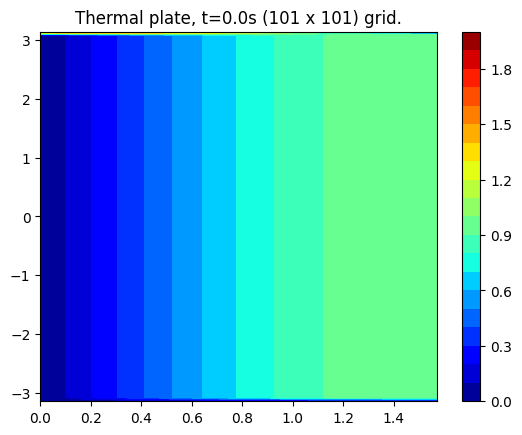

In [3]:
# Set up the test problem
def thermal_plate(ni,nj):
    
   # Initialize the grid class with ni and nj grid points
    mesh = Grid(ni,nj)
    
    # Set origin and extent of grid
    mesh.set_origin(0, -np.pi)
    mesh.set_extent(np.pi * 0.5, 2*np.pi)
    
    # Set diffusivity
    mesh.set_diffusivity(0.2)
    
    # This generates the grid
    mesh.generate()
     
    # Now set the inital conditions
    mesh.u = np.sin(mesh.x)
    
    return mesh

def set_boundary_conditions(mesh,time):
    '''Function that sets the boundary conditions. This functions takes 
       as input a mesh (mesh) and a time step (time)'''
    
    # Set x = 0 boundary
    mesh.u[:,0] = time
    
    # Set x = 0.5pi boundary
    mesh.u[:,-1] = np.exp(-mesh.kappa * time)
    
    # Set y = -pi boundary
    mesh.u[0,:] = 0

    # Set y = pi boundary
    mesh.u[-1,:] = 2 * np.cos(mesh.x[-1,:]) * np.exp(-mesh.kappa * time)

# Calling the thermal_plate() function creates a 101 x 101 grid and applies boundary conditions
test = thermal_plate(101, 101)

# Call the function to set up boundary conditions for the first time step (t=0)
set_boundary_conditions(test, 0.0)

# Prints description of the object
print(test)

# Plot initial array
test.plot('Thermal plate')

In [4]:
def L_x(mesh, dt):
    '''One dimensional operator in the x-direction.'''
    
    # Calculate beta coefficient
    beta = mesh.kappa*dt/mesh.Delta_x()**2
    
    # Create a copy of the solution array to be used in the update step
    u = mesh.u.copy()
    
    # Whole array operations for L_x update 
    mesh.u[1:-1,1:-1] = u[1:-1,1:-1] \
    + beta * (u[1:-1,0:-2]-2*u[1:-1,1:-1]+u[1:-1,2:])
    
def L_y(mesh, dt):
    '''One dimensional opperator in the y-direction.'''
    
    # Calculate beta coefficient
    beta = mesh.kappa*dt/mesh.Delta_y()**2
    
    # Create a copy of the solution array to be used in the update step
    u = mesh.u.copy()
    
    # Whole array operations for L_y update 
    mesh.u[1:-1,1:-1] = u[1:-1,1:-1] \
    + beta * (u[0:-2,1:-1]-2*u[1:-1,1:-1]+u[2:,1:-1])

    
def operator_split(mesh, t_stop, nu=0.95):
    ''' 2D operator split explicit time marching method.
    The function useds the Lx an Ly opperators on the
    specified mesh.  time step is calculated using the
    specified value of the courant number, nu. and the
    solution is advanced until t_stop is reached.
    '''

    # Calculate the time step
    delta_t = nu * min(mesh.Delta_x()**2/(2*mesh.kappa),
                        mesh.Delta_y()**2/(2*mesh.kappa))
    print('time marching with dt={:.3f}'.format(delta_t))
    
    # Calculate the maximum number of iterations
    maxit = int(np.ceil(t_stop/delta_t))+1
    
    # How many iterations to report progress
    check = maxit // 20
    
    # Loop over time window
    for it in range(maxit):
        
        # Check time step
        delta_t=min(delta_t, t_stop-mesh.time)
        
        # Apply boundary conditions
        set_boundary_conditions(mesh, mesh.time)
        
        # Update step
        L_y(mesh, delta_t)
        L_x(mesh, delta_t)
        
        # Update time step for next iteration
        mesh.time += delta_t
        
        # progress
        if it % check == 0 :
            print('#', end='')
            
    print(f'\n Completed in {it} time steps.')

time marching with dt=0.002
#####################
 Completed in 2134 time steps.
Solver took 0.124 seconds.


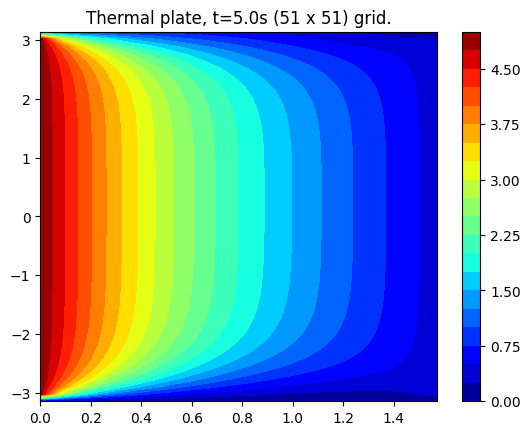

In [7]:
# Calling the thermal_plate() function creates a 201 x 201 grid and applies boundary conditions

test = thermal_plate(51, 51)

# Record starting time
start = time.process_time()

# Compute the solution using operator splitting for 3600 seconds
operator_split(test,5)

# Record end time and report total time required
stop = time.process_time()
print("Solver took {:.3g} seconds.".format(stop-start))

# Plot solution
plt = test.plot('Thermal plate')

# Save plot
#plt.savefig('thermal_plate.pdf')